In [79]:
import numpy as np
import pandas as pd
import sklearn
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from itertools import chain
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
#load pre-trained embedding:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/MinorProject/crawl-300d-2M.vec.zip", 'r')
zip_ref.extractall()
zip_ref.close()
embeddings_index = {}
f = open('/content/crawl-300d-2M.vec', encoding="utf8")
for line in f:
    values = line.split()#This splits each values in a  line with spaces
    word = values[0] # This store the first values which is the word in english
    coefs = np.asarray(values[1:], dtype='float32') # This converts all splitted values from 1 to last(expect first word) into an array
    embeddings_index[word] = coefs # english word = array of numerical values
f.close()
print('Total %s word vectors in crawl-300-2M.' % len(embeddings_index))

Total 1999996 word vectors in crawl-300-2M.


In [122]:
df1=pd.read_csv('/content/drive/My Drive/MinorProject/agr_hi_dev.csv',names=['File_ID','Text','label'])
df1=df1.drop(columns=['File_ID'])
df1.head()

,Text,label
0,RANDTV tumhare najayaz baap is area hai ki wah...,OAG
1,First stage par dus jootey khaye Grover se,OAG
2,Salman aur aamir ki kounsi movie release huyee...,OAG
3,Wk aur bhakt aa gya. Abe americans ka bolna h...,CAG
4,Beta to tu apne baap ka hai ...permission to t...,NAG


In [123]:
df2=pd.read_csv('/content/drive/My Drive/MinorProject/agr_hi_fb_gold.csv',names=['File_ID','Text','label'])
df2=df2.drop(columns=['File_ID'])
df2.head()

,Text,label
0,Abe movi m bhi dhrm agya kya paglpnti h ye,OAG
1,Badnam Gujat kutte ki olaad madrchod Pakistani...,OAG
2,Modi ji aap ek bar Up ka CM ko ye afar de fir ...,CAG
3,Kya hota hai ji jb koi pm bn jaata hai to itna...,CAG
4,मुसलमान अपना धर्म तो जानते नही लेकिन काँपी कर ...,OAG


In [124]:
df3=pd.read_csv('/content/drive/My Drive/MinorProject/agr_hi_tw_gold.csv',names=['File_ID','Text','label'])
df3=df3.drop(columns=['File_ID'])
df3.head()

,Text,label
0,Tera baap bambani h .. bambani .. ambani nhi #...,CAG
1,Aaj wicket jane per khushi kaam ho hai.... #IN...,NAG
2,चौका मारकर इतना उड़ रहे हो 😳 सालों छक्का मारा त...,OAG
3,RT @ErVishalInsan: #BlockBusterMSG #MustWatchM...,NAG
4,शिट #IndvsPak,CAG


In [125]:
df4 = pd.read_csv("/content/drive/My Drive/MinorProject/hin_train.csv")
df4 = df4.drop(columns=['ID', 'Sub-task B'])
df4 = df4.rename(columns={'Sub-task A' : 'label'})
df4.head()

,Text,label
0,Bollywood film dekhne ke samay logic ghar mein...,NAG
1,Chutiya movie...,NAG
2,Us jaat bnde ka khene ka matlab tha mar daluga...,OAG
3,@Feminism Is CANCER *un feminist yeh sahi hai ...,OAG
4,Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने,NAG


In [126]:
train_df=pd.concat([df1,df2,df3,df4])
train_df.head()

,Text,label
0,RANDTV tumhare najayaz baap is area hai ki wah...,OAG
1,First stage par dus jootey khaye Grover se,OAG
2,Salman aur aamir ki kounsi movie release huyee...,OAG
3,Wk aur bhakt aa gya. Abe americans ka bolna h...,CAG
4,Beta to tu apne baap ka hai ...permission to t...,NAG


In [127]:
train_df['label'] = train_df['label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
train_df

,Text,label
0,RANDTV tumhare najayaz baap is area hai ki wah...,2
1,First stage par dus jootey khaye Grover se,2
2,Salman aur aamir ki kounsi movie release huyee...,2
3,Wk aur bhakt aa gya. Abe americans ka bolna h...,1
4,Beta to tu apne baap ka hai ...permission to t...,0
...,...,...
3979,Asexual h.. bisexual... homosexual... bhai ase...,0
3980,Video pura dekne ke pahile hi mai bhai ke vide...,0
3981,konsa place hai bhai ...nam bolo,0
3982,Kuch zada hi likh diya 🙄,0


In [128]:
test_df = pd.read_csv("/content/drive/My Drive/MinorProject/hin_dev.csv")
test_df = test_df.drop(columns=['ID', 'Sub-task B'])
test_df = test_df.rename(columns={'Sub-task A' : 'label'})
test_df['label'] = test_df['label'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
test_df

,Text,label
0,bkl interviewers kuch jaada hi open minded bnt...,2
1,Bhaiya shaadi mein zaroor aana movie ka plot j...,0
2,Section 375 hai kya??? .... Ye to batate kam s...,0
3,कबीर सिंह hit Hui इससे पता चलता है आजकल के लोग...,2
4,Maine itni kam dislike kbhi nhii dekhi,0
...,...,...
992,Are bhai konsi duniya mai rehate ho😂😂,0
993,Sahi to bola,0
994,Or tum Kay Kar raya ho?,0
995,Ye bhaat sahi hain par zyada dhin thine ga nah...,0


In [129]:
train_df.shape, test_df.shape

((9149, 2), (997, 2))

In [130]:
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

0    3332
2    2948
1    2869
Name: label, dtype: int64
0    578
1    211
2    208
Name: label, dtype: int64


In [131]:
train_line=train_df['Text'].apply(lambda x: nltk.word_tokenize(str(x)))
dev_line=test_df['Text'].apply(lambda x: nltk.word_tokenize(str(x)))
dev_line,train_line

(0      [bkl, interviewers, kuch, jaada, hi, open, min...
 1      [Bhaiya, shaadi, mein, zaroor, aana, movie, ka...
 2      [Section, 375, hai, kya, ?, ?, ?, ..., ., Ye, ...
 3      [कबीर, सिंह, hit, Hui, इससे, पता, चलता, है, आज...
 4         [Maine, itni, kam, dislike, kbhi, nhii, dekhi]
                              ...                        
 992        [Are, bhai, konsi, duniya, mai, rehate, ho😂😂]
 993                                     [Sahi, to, bola]
 994                     [Or, tum, Kay, Kar, raya, ho, ?]
 995    [Ye, bhaat, sahi, hain, par, zyada, dhin, thin...
 996          [Islye, maine, Kabaad, singh, nai, dekha..]
 Name: Text, Length: 997, dtype: object,
 0       [RANDTV, tumhare, najayaz, baap, is, area, hai...
 1       [First, stage, par, dus, jootey, khaye, Grover...
 2       [Salman, aur, aamir, ki, kounsi, movie, releas...
 3       [Wk, aur, bhakt, aa, gya, ., Abe, americans, k...
 4       [Beta, to, tu, apne, baap, ka, hai, ..., permi...
                          

In [132]:
tk=Tokenizer(lower=True,split=" ")
tk.fit_on_texts(train_line)
word_index=tk.word_index
word_index

{'...': 1,
 'hai': 2,
 ',': 3,
 '.': 4,
 '#': 5,
 'ki': 6,
 'ko': 7,
 'है': 8,
 'के': 9,
 'ke': 10,
 'to': 11,
 'ka': 12,
 'की': 13,
 '?': 14,
 'को': 15,
 'se': 16,
 'me': 17,
 'में': 18,
 'h': 19,
 '!': 20,
 'से': 21,
 'और': 22,
 'ho': 23,
 'bhi': 24,
 'nahi': 25,
 'ye': 26,
 'का': 27,
 'aur': 28,
 'hi': 29,
 'bhai': 30,
 'k': 31,
 ':': 32,
 '@': 33,
 'kya': 34,
 'तो': 35,
 'भी': 36,
 'kar': 37,
 'पर': 38,
 'nhi': 39,
 'हो': 40,
 'movie': 41,
 'jo': 42,
 'ek': 43,
 'कर': 44,
 'ही': 45,
 'नहीं': 46,
 'or': 47,
 'koi': 48,
 'he': 49,
 'ne': 50,
 'na': 51,
 'हैं': 52,
 'hain': 53,
 ')': 54,
 'aap': 55,
 'log': 56,
 'ab': 57,
 'desh': 58,
 'kuch': 59,
 'modi': 60,
 'ने': 61,
 'एक': 62,
 '..': 63,
 "''": 64,
 '(': 65,
 'ये': 66,
 'liye': 67,
 'tha': 68,
 'pakistan': 69,
 'ji': 70,
 'review': 71,
 'india': 72,
 'toh': 73,
 'pe': 74,
 'wo': 75,
 'नही': 76,
 'क्या': 77,
 'baat': 78,
 'mein': 79,
 'है।': 80,
 'raha': 81,
 'sahi': 82,
 'par': 83,
 'देश': 84,
 'tum': 85,
 'is': 86,
 'tu': 87,
 '

In [133]:
import math
length=math.ceil(np.average(train_line.apply(lambda x:len(x))))
length

26

In [0]:
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

In [135]:
train_x=encode_text(tk,train_line,length)
print(train_x.shape)
dev_x=encode_text(tk,dev_line,length)
print(dev_x.shape)

(9149, 26)
(997, 26)


In [136]:
vocab_size = len(tk.word_index)
print(vocab_size)

33452


In [137]:
from keras.utils.np_utils import to_categorical
x1=train_df['label']
x2=test_df['label']
y_train = to_categorical(np.asarray(x1))
y_test = to_categorical(np.asarray(x2))
print(y_train.shape, y_test.shape)

(9149, 3) (997, 3)


In [0]:
# Initialize the weight for each word for the embedding layer. Words not present
# in the dictionary initialized by random value 
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#embedding_matrix = (10370, 300) NOTE: It is from uniques words in our tweets
for word, i in word_index.items(): # Selecting word from our tweet unique words list for changing with the values from glove
    embedding_vector = embeddings_index.get(word) # Finding our tweet words in glove and taking its array of 100 values
    if embedding_vector is not None: 
#words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [139]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 300, weights=[embedding_matrix], input_length=length,trainable=False))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 300)           10035900  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 128)           115328    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

In [140]:
history=model.fit(train_x, y_train, validation_data = (dev_x, y_test),epochs=120,batch_size=100, verbose=2)

Train on 9149 samples, validate on 997 samples
Epoch 1/120
 - 1s - loss: 1.1069 - acc: 0.4138 - val_loss: 0.9985 - val_acc: 0.5256
Epoch 2/120
 - 1s - loss: 1.0278 - acc: 0.4550 - val_loss: 0.8713 - val_acc: 0.5898
Epoch 3/120
 - 1s - loss: 0.9766 - acc: 0.4952 - val_loss: 0.8558 - val_acc: 0.6098
Epoch 4/120
 - 1s - loss: 0.9407 - acc: 0.5285 - val_loss: 0.8401 - val_acc: 0.6189
Epoch 5/120
 - 1s - loss: 0.9112 - acc: 0.5473 - val_loss: 0.8196 - val_acc: 0.6148
Epoch 6/120
 - 1s - loss: 0.8838 - acc: 0.5661 - val_loss: 0.8051 - val_acc: 0.6299
Epoch 7/120
 - 1s - loss: 0.8567 - acc: 0.5850 - val_loss: 0.8279 - val_acc: 0.6169
Epoch 8/120
 - 1s - loss: 0.8141 - acc: 0.6085 - val_loss: 0.8152 - val_acc: 0.6429
Epoch 9/120
 - 1s - loss: 0.7837 - acc: 0.6308 - val_loss: 0.8213 - val_acc: 0.6469
Epoch 10/120
 - 1s - loss: 0.7384 - acc: 0.6518 - val_loss: 0.8470 - val_acc: 0.6479
Epoch 11/120
 - 1s - loss: 0.7172 - acc: 0.6621 - val_loss: 0.8377 - val_acc: 0.6499
Epoch 12/120
 - 1s - loss: 

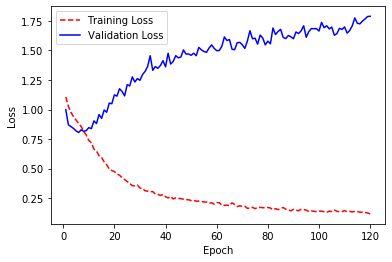

In [141]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [142]:
scores = model.evaluate(dev_x, y_test, verbose=0)
print(scores)

[1.7899249872508474, 0.6208625877632898]


In [143]:
predictions_test = model.predict(dev_x)
print(predictions_test)

[[3.9561249e-07 8.3054340e-01 1.6945615e-01]
 [9.5421892e-01 4.5781009e-02 1.6936012e-07]
 [4.1003913e-01 1.5613190e-03 5.8839959e-01]
 ...
 [9.6011257e-01 6.6492679e-03 3.3238232e-02]
 [8.3978683e-01 1.5836942e-01 1.8437597e-03]
 [9.6110314e-01 1.9074097e-02 1.9822704e-02]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [145]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       578
           1       0.38      0.42      0.40       211
           2       0.49      0.46      0.47       208

   micro avg       0.62      0.62      0.62       997
   macro avg       0.54      0.54      0.54       997
weighted avg       0.62      0.62      0.62       997
 samples avg       0.62      0.62      0.62       997

